In [344]:
import cv2
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.segmentation import clear_border
from scipy import ndimage

import omero.clients
from getpass import getpass
from omero.gateway import BlitzGateway, ColorHolder, rint,rdouble, rstring
from omero.model import RoiI, MaskI, ImageI, PolygonI, LengthI
from omero.model.enums import UnitsLength
import struct

# need credentials
# username=input("Username: ")
# password=getpass("OMERO Password: ")
username="thomas.hanke"
password="peter123"


HOST = 'wss://wss.omero.matolab.org'
client = omero.client(HOST)

def test_connect():
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        print("Connected as {}".format(conn.getUser().getName()))
        print("User ID: {}".format(conn.getUser().getId()))
        print("User Full Name: {}".format(conn.getUser().getFullName()))

        print("Your Groups:")
        for g in conn.getGroupsMemberOf():
            print("   Name:", g.getName(), " ID:", g.getId())
        group = conn.getGroupFromContext()
        print("Current group: ", group.getName())

def get_datasets():
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        #demo project
        project=conn.getObject("Project", 51)
        return list(project.listChildren())

# Load images in a specified dataset method
def get_images(conn, dataset_id):
    """
    Load the images in the specified dataset
    :param conn: The BlitzGateway
    :param dataset_id: The dataset's id
    :return: The Images or None
    """
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        dataset = conn.getObject("Dataset", dataset_id)
        images = []
        if dataset:
            for image in dataset.listChildren():
                images.append(image)
            if len(images) == 0:
                return None

        for image in images:
            print("---- Loaded image ID:", image.id)
        
        # Print dataset ID and name
        print("Dataset ID:", dataset.getId())
        print("Dataset Name:", dataset.getName())
    return images

def create_mask(mask_bytes, bytes_per_pixel=1):
    if bytes_per_pixel == 2:
        divider = 16.0
        format_string = "H"  # Unsigned short
        byte_factor = 0.5
    elif bytes_per_pixel == 1:
        divider = 8.0
        format_string = "B"  # Unsigned char
        byte_factor = 1
    else:
        message = "Format %s not supported"
        raise ValueError(message)
    steps = math.ceil(len(mask_bytes) / divider)
    mask = []
    for i in range(int(steps)):
        binary = mask_bytes[
            i * int(divider):i * int(divider) + int(divider)]
        format = str(int(byte_factor * len(binary))) + format_string
        binary = struct.unpack(format, binary)
        s = ""
        for bit in binary:
            s += str(bit)
        mask.append(int(s, 2))
    return bytearray(mask)

# We have a helper function for creating an ROI and linking it to new shapes
def create_roi(img_id, shapes):
    # create an ROI, link it to Image
    roi = RoiI()
    # use the omero.model.ImageI that underlies the 'image' wrapper
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        img = conn.getObject("Image", img_id)
        roi.setImage(ImageI(img_id, False))
        for shape in shapes:
            roi.addShape(shape)
        # Save the ROI (saves any linked shapes too)
        updateService=conn.getUpdateService()
        return updateService.saveAndReturnObject(roi)

def delete_rois(image_id):
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        roi_service = conn.getRoiService()
        result = roi_service.findByImage(image_id, None)
        roi_ids = [roi.id.val for roi in result.rois]
        if roi_ids:
            conn.deleteObjects("Roi", roi_ids)
        print("deleted rois: {}".format(roi_ids)) 

def rgba_to_int(red, green, blue, alpha=255):
    """ Return the color as an Integer in RGBA encoding """
    r = red << 24
    g = green << 16
    b = blue << 8
    a = alpha
    rgba_int = r+g+b+a
    if (rgba_int > (2**31-1)):       # convert to signed 32-bit int
        rgba_int = rgba_int - 2**32
    return rgba_int

def print_image_details(img_id):
    # Retrieve information about the image
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        image = conn.getObject("Image", img_id)
        print("Image Name:", image.getName())
        print("Image Name:", image.id)
        print("Image Description:", image.getDescription())
        print("Image SizeX:", image.getSizeX())
        print("Image SizeY:", image.getSizeY())
        print("Image SizeZ:", image.getSizeZ())
        print("Image SizeC:", image.getSizeC())
        print("Image SizeT:", image.getSizeT())

        x = image.getName()

        # List Channels (loads the Rendering settings to get channel colors)
        for channel in image.getChannels():
            print('Channel:', channel.getLabel())
            print('Color:', channel.getColor().getRGB())
            print('Lookup table:', channel.getLut())
            print('Is reverse intensity?', channel.isReverseIntensity())
            

        print(image.countImportedImageFiles())
        file_count = image.countFilesetFiles()
        # list files
        if file_count > 0:
            for orig_file in image.getImportedImageFiles():
                name = orig_file.getName()
                path = orig_file.getPath()
                print(name)
                print(path)
    return x
def get_grayscale(img_id):
    session = client.createSession(username, password)
    with BlitzGateway(client_obj=client) as conn:
        image = conn.getObject("Image", img_id)
        z = image.getSizeZ() / 2
        t = 0
        rendered_image = image.renderImage(z, t)
        image_array = np.asarray(rendered_image)
        # Convert the image to grayscale
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    return gray
    
# def create_omero_roi_masks(image_id):
#     mask_x = 50
#     mask_y = 50
#     mask_h = 100
#     mask_w = 100
#     # Create [0, 1] mask
#     mask_array = np.fromfunction(
#         lambda x, y: (x * y) % 2, (mask_w, mask_h))
#     # Set correct number of bytes per value
#     mask_array = mask_array.astype(np.uint8)
#     # Convert the mask to bytes
#     mask_array = mask_array.tobytes()
#     # Pack the bytes to a bit mask
#     mask_packed = create_mask(mask_array, 1)

#     # Define mask's fill color
#     mask_color = ColorHolder()
#     mask_color.setRed(255)
#     mask_color.setBlue(0)
#     mask_color.setGreen(0)
#     mask_color.setAlpha(100)
#     # create an ROI with a single mask
#     mask = MaskI()
#     mask.setTheC(rint(0))
#     mask.setTheZ(rint(0))
#     mask.setTheT(rint(0))
#     mask.setX(rdouble(mask_x))
#     mask.setY(rdouble(mask_y))
#     mask.setWidth(rdouble(mask_w))
#     mask.setHeight(rdouble(mask_h))
#     mask.setFillColor(rint(mask_color.getInt()))
#     mask.setTextValue(rstring("test-Mask"))
#     mask.setBytes(mask_packed)
#     return create_roi(image_id, [mask])

def create_omero_roi_polygons(image_id,contours):
    the_t = 0
    the_z = 0
    polygons = []
    # create an ROI with a single polygon
    for i,contour in enumerate(contours):
        polygon = PolygonI()
        polygon.theZ = rint(the_z)
        polygon.theT = rint(the_t)
        color = list(np.random.choice(range(256), size=3))
        polygon.strokeColor = rint(rgba_to_int(color[0], color[1], color[2]))
        polygon.fillColor = rint(rgba_to_int(color[0], color[1], color[2]))
        
        polygon.strokeWidth = LengthI(1, UnitsLength.PIXEL)
        pts=["{},{}".format(point[:,0][0],point[:,1][0]) for point  in contour]
        pts_list=" ".join(pts)
        polygon.points = rstring(pts_list)
        #print(pts_list[:30])
        polygon.textValue = rstring("Precipitate"+str(i))
        polygons.append(polygon)
    #print(polygon.info())
    #print(polygon.__dir__())
    create_roi(image_id, polygons)
    print("added {} polygon shapes to image".format(len(polygons)))
    
test_connect()
datasets=get_datasets()

Connected as thomas.hanke
User ID: 102
User Full Name: Thomas Hanke
Your Groups:
   Name: matolab  ID: 53
   Name: kupferdigital  ID: 54
Current group:  matolab


In [346]:
def run_detection(image,save_to_file=False):
    #name=print_image_details(image.id)

    name=image.name
    print("Image Name: "+name)

    # print(image.__dir__)
    ### Time estimation of the pipeline
    import time
    startTime = time.time()
    x = name.split('_')
    #MaterialState (T61), Sample (Sample1), Image (Stelle1)
    # Print the shape and data type of the grayscale image
    gray=get_grayscale(image.id)

    print("Grayscale image shape:", gray.shape)
    print("Grayscale image data type:", gray.dtype)

    # Apply median filter using OpenCV
    radius = 4
    selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius + 1, 2*radius+1))
    filtered = cv2.medianBlur(gray, 2 * radius + 1)

    # Display the original and filtered images side by side
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(gray, cmap='gray')
    ax0.set_title('Step1: Load Original Image')
    ax0.axis('off')
    ax1.imshow(filtered, cmap='gray')
    ax1.set_title('Step2: Median Blur Filter')
    ax1.axis('off')

    # Apply Otsu's thresholding using OpenCV
    ret, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print('Threshold value is {}'.format(ret))

    # Dilate the thresholded image using a 3x3 kernel
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(thresh, kernel)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(thresh, cmap='gray')
    ax0.set_title('Step3: Otsu Threshold')
    ax0.axis('off')
    ax1.imshow(dilated, cmap='gray')
    ax1.set_title('Step4: Dilated Image')
    ax1.axis('off')

    # Remove small objects using OpenCV's morphologyEx function
    size_thresh = 80
    morphed = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(morphed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < size_thresh:
            cv2.drawContours(morphed, [cnt], 0, 0, -1)

    # delete all previously defined shapes
    delete_rois(image.id)

    # upload shapes to omero
    create_omero_roi_polygons(image.id,contours)

    # Apply clear border to the dilated image
    mask = morphed  == 255
    mask = clear_border(mask)

    # Label the mask and count the number of precipitates detected
    s = [[1,1,1],[1,1,1],[1,1,1]]
    labeled_mask, num_labels = ndimage.label(mask, structure=s)
    img2 = label2rgb(labeled_mask, bg_label=0)

    # Display the labeled mask
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img2)
    ax.set_title('Step5: Contour Finding')
    ax.axis('off')
    plt.show()
    print(f"Number of precipitates detected: {num_labels}")

    plt.show()
    

## The Pipline

---- Loaded image ID: 83
---- Loaded image ID: 84
---- Loaded image ID: 85
---- Loaded image ID: 74
---- Loaded image ID: 75
---- Loaded image ID: 76
---- Loaded image ID: 77
---- Loaded image ID: 78
---- Loaded image ID: 79
---- Loaded image ID: 80
---- Loaded image ID: 81
---- Loaded image ID: 82
Dataset ID: 53
Dataset Name: 190C_1000h
Image Name: 190C-1000h_Sample1_Stelle 10 DF 30s.dm3
Grayscale image shape: (2048, 2048)
Grayscale image data type: uint8
Threshold value is 61.0


AttributeError: Must be a list of object IDs

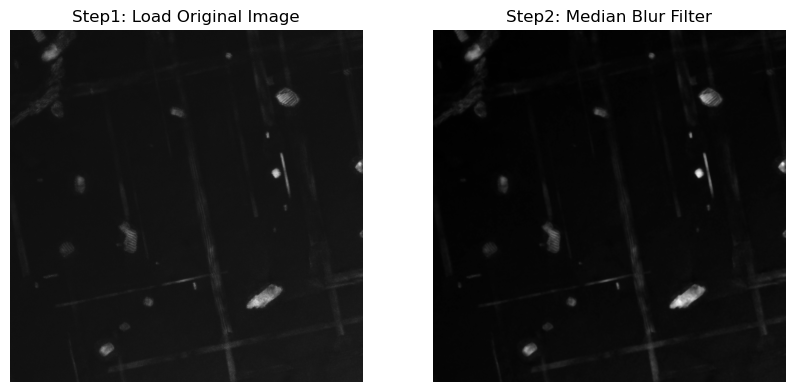

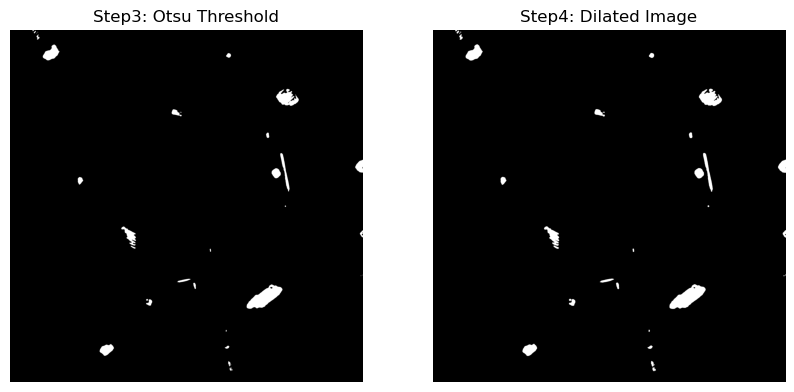

In [347]:
# Get the images in a dataset and print the dataset ID and name
dataset=datasets[0]
images = get_images(conn, dataset.id)

for image in images:
    run_detection(image)
    

In [19]:
# Extract properties of each labeled region
props = regionprops_table(labeled_mask, image, properties=('area',
                                                                    'axis_major_length',
                                                                   'axis_minor_length',
                                                                      'centroid',))

# Create a Pandas dataframe from the properties
df = pd.DataFrame(props)

area_in_nm2 = df['area'] * 0.0225
df['area_in_nm2'] = area_in_nm2

radius_in_nm = np.sqrt(df['area_in_nm2']/math.pi)
df['radius_in_nm'] = radius_in_nm
aspect_ratio = df['axis_major_length']/df['axis_minor_length']
df.insert(3, 'aspect_ratio', aspect_ratio)

#To delete small regions...
df = df[df['area'] > 50]

df.head()

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm
0,151.0,20.199242,9.719404,2.078239,17.370861,143.768212,3.3975,1.039932
1,376.0,31.472202,17.716499,1.776435,47.223404,161.465426,8.4600,1.641006
2,5370.0,108.892965,66.531422,1.636715,140.868715,239.616760,120.8250,6.201596
3,648.0,30.067171,27.751492,1.083443,153.118827,1268.279321,14.5800,2.154288
4,8279.0,129.952189,88.777529,1.463796,400.818819,1607.028868,186.2775,7.700258


### Creating the Meta-data

In [ ]:
date = pd.Timestamp("today").strftime("%Y-%m-%d")

In [ ]:
header = {'BitSizeValue': radius , 
          'DiskRadiusValue[pixel]': 8,
          'OtsuThresholdValue[np]': 'Otsu',
          'KernelValue':3,
          'MaskSetValue':255, 
          'BG_LabelValue':0,
          'Date':date}

In [ ]:
df_header= pd.DataFrame([header])

In [ ]:
df_header.head(4)

,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,4,8,Otsu,3,255,0,2023-04-05


### Joining the meta-data to the dataframe

In [ ]:
df_join = df.join(df_header, rsuffix='_right')
df_join.head(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
1,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# filling the NaN values
df_join=df_join.fillna(method='ffill')
df_join.tail(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
21,731,51.693956,22.115508,2.337453,1776.905609,1725.340629,16.4475,2.288100,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
22,112,12.546236,11.380204,1.102461,1912.223214,1874.250000,2.5200,0.895623,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
23,144,15.267990,12.038693,1.268243,1914.729167,1892.145833,3.2400,1.015541,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
24,107,12.786384,10.634679,1.202329,1939.728972,1913.934579,2.4075,0.875403,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
25,332,28.529056,15.152586,1.882785,1976.888554,377.057229,7.4700,1.542004,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05


### Creating informative columns 

In [ ]:
df_join['Precipitate#'] = range(1,len(df_join)+1)
df_join.head(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
0,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,1
1,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,2
2,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,3
3,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,4
4,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,5


In [ ]:

desc = {'MaterialState':x[0] , 
         'Sample': x[1],
          'Image': x[2],
         }

df_desc= pd.DataFrame([desc])
df_desc.head()

,MaterialState,Sample,Image
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3


In [ ]:
#df_join = df.join(df_desc, lsuffix='_MaterialState')
frames = [df_desc, df_join]

result = pd.concat(frames, axis="columns")
result.head(5)

,MaterialState,Sample,Image,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,1
1,NaN,NaN,NaN,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,2
2,NaN,NaN,NaN,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,3
3,NaN,NaN,NaN,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,4
4,NaN,NaN,NaN,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,5


In [ ]:
# Fill the missing data
df_join=result.fillna(method='ffill')
df_join.tail(5)

,MaterialState,Sample,Image,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
21,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,731,51.693956,22.115508,2.337453,1776.905609,1725.340629,16.4475,2.288100,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,22
22,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,112,12.546236,11.380204,1.102461,1912.223214,1874.250000,2.5200,0.895623,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,23
23,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,144,15.267990,12.038693,1.268243,1914.729167,1892.145833,3.2400,1.015541,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,24
24,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,107,12.786384,10.634679,1.202329,1939.728972,1913.934579,2.4075,0.875403,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,25
25,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,332,28.529056,15.152586,1.882785,1976.888554,377.057229,7.4700,1.542004,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,26


In [ ]:
df_join['Image'] = df_join['Image'].str.replace('.dm3', '', regex=True)

In [ ]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [ ]:
df_final_result = change_column_order(df_join, 'Precipitate#', 3)

In [ ]:
df_final_result = df_final_result.rename(columns={"centroid-0": "centroid-X", "centroid-1": "centroid-Y"})

In [ ]:
df_final_result.head(5)

,MaterialState,Sample,Image,Precipitate#,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-X,centroid-Y,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,1,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
1,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,2,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
2,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,3,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
3,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,4,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
4,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,5,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05


In [ ]:
df_final_result.to_csv('190c_2500h_1iteration.csv',  header=False, mode='a',index=False, date_format='%s')